# Practical Lab 5 - Multivariate Regression, Non-Parametric Models and Cross-Validation
## 1. Get the data
Data Source: [link](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset)

In [92]:
from sklearn import datasets
diabetes = datasets.load_diabetes(as_frame=True)

# 2. EDA

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

diabetes_df = diabetes.frame
diabetes_df.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


The dataset comprises a total of 10 independent variables as follows:
- Age in years
- Sex
- Body Mass Index (BMI)
- Average blood pressure (BP)
- TC, total serum cholesterol (S1)
- LDL, low-density lipoproteins (S2)
- HDL, high-density lipoproteins (S3)
- TCH, total cholesterol / HDL (S4)
- LTG, possibly the log of serum triglycerides level (S5)
- Glucose level (S6)

It is noted that the values of the first 10 columns have been scaled by the standard deviation times the square root of the number of samples so that the sum of squares of each column totals 1. This scaling is a form of standardization to ensure that each feature contributes equally to the analysis.<br>The target, the last column, quantitatively represents the degree of disease progression one year after baseline.

<Axes: >

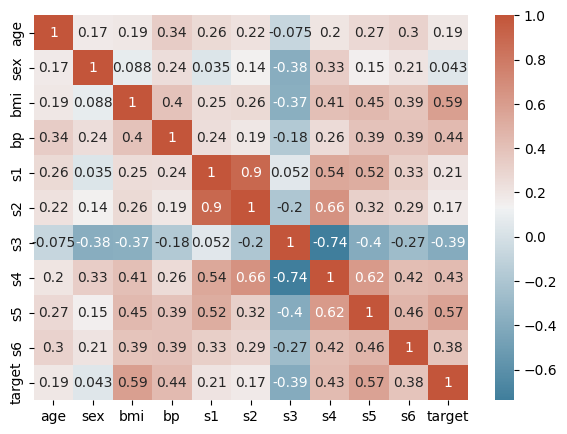

In [94]:
f, ax = plt.subplots(figsize=(7, 5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(diabetes_df.corr(), annot=True, cmap=cmap)

When designing this model, the aim was to select the two independent variables most closely associated with the target value. Upon examining the results through a correlation matrix, it was found that the BMI values and the log of serum triglycerides levels have the highest correlation with the target. Therefore, these two variables will be used to construct the model.

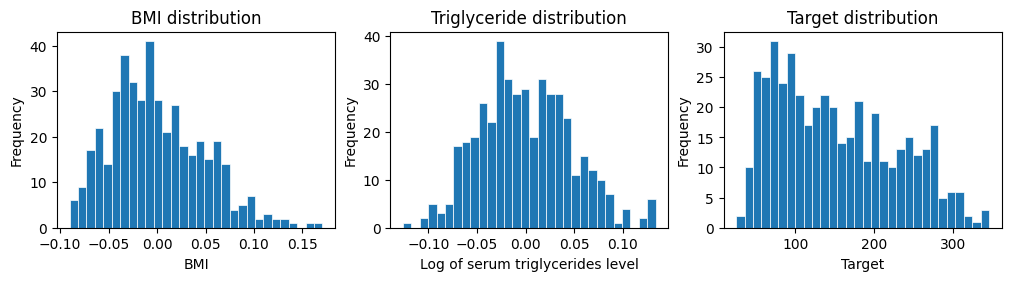

In [95]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 2.7), layout='constrained')
ax1.hist(diabetes_df['bmi'], bins=30, linewidth=0.5, edgecolor="white")
ax1.set_title('BMI distribution')
ax1.set_xlabel('BMI')
ax1.set_ylabel('Frequency')

ax2.hist(diabetes_df['s5'], bins=30, linewidth=0.5, edgecolor="white")
ax2.set_title('Triglyceride distribution')
ax2.set_xlabel('Log of serum triglycerides level')
ax2.set_ylabel('Frequency')

ax3.hist(diabetes_df['target'], bins=30, linewidth=0.5, edgecolor="white")
ax3.set_title('Target distribution')
ax3.set_xlabel('Target')
ax3.set_ylabel('Frequency')

plt.show()

This histogram displays the distribution of BMI and Triglyceride levels. From the histogram, it can be observed that both variables exhibit distributions close to a normal distribution. The BMI values range between -0.1 and 0.2, while Triglyceride levels are found between 0 and 0.15. This range can be attributed to the application of logarithmic values. The target value, representing the degree of diabetes progression, ranges from 0 to 350.

# 3. Drop some features per your discretion based on the EDA.

In [96]:
diabetes_df = diabetes_df[['bmi', 's5', 'target']]
diabetes_df

,bmi,s5,target
0,0.061696,0.019907,151.0
1,-0.051474,-0.068332,75.0
2,0.044451,0.002861,141.0
3,-0.011595,0.022688,206.0
4,-0.036385,-0.031988,135.0
...,...,...,...
437,0.019662,0.031193,178.0
438,-0.015906,-0.018114,104.0
439,-0.015906,-0.046883,132.0
440,0.039062,0.044529,220.0


From the entire dataset, only the data necessary for model construction, which are the BMI, s5 (log of serum triglycerides level), and target values, have been retained, and the rest have been removed.

# 4. Set a test-set aside

In [97]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(diabetes_df, test_size=0.20, random_state=0)

To perform cross-validation, the entire dataset was first divided into a train set and a test set. The division was made with 80% of the data allocated to the train set and 20% to the test set. During the cross-validation process, the train set will be further divided into 5 folds. Therefore, during cross-validation, the train data will constitute 64% of the total dataset, and the validation data will make up 16% of the total dataset.

# 5. Perform cross-validation

## 5-1. Polynomial Models

In [98]:
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import numpy as np

In [99]:
cross_val_scores_poly = []
scoring = {'r2': 'r2', 'neg_mean_absolute_error': 'neg_mean_absolute_error', 
            'neg_mean_absolute_percentage_error': 'neg_mean_absolute_percentage_error'}

degrees = np.arange(1, 3)
for degree in degrees:
    # Create a pipeline that creates polynomial features, then applies linear regression
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    # Use cross-validation to compute the mean score across multiple splits of the data
    scores = cross_validate(model, X=train[['bmi', 's5']], y=train[['target']], scoring=scoring, cv=5)
    cross_val_scores_poly.append(scores)


## 5-2. Decision Tree Models

In [109]:
from sklearn import tree

cross_val_scores_dt = []

depths = np.arange(3, 5)
for depth in depths:
    clf = tree.DecisionTreeRegressor(max_depth=depth)
    scores = cross_validate(clf, X=train[['bmi', 's5']], y=train[['target']], scoring=scoring, cv=5)
    cross_val_scores_dt.append(scores)


## 5-3. kNNs Models

In [110]:
from sklearn.neighbors import KNeighborsRegressor

cross_val_scores_knn = []

neighbors = np.arange(5, 7)
for neighbor in neighbors:
    knn = KNeighborsRegressor(n_neighbors=neighbor)
    scores = cross_validate(knn, X=train[['bmi', 's5']], y=train[['target']], scoring=scoring, cv=5)
    cross_val_scores_knn.append(scores)


# 6. Construct a table summarizing the cross-validation results

In [112]:
# print scores for polynomial models
print("Polynomial Regression")
for degree in degrees:
    score = cross_val_scores_poly[degree-1]
    r2_mean = score['test_r2'].mean()
    r2_std = score['test_r2'].std()
    mae_mean = -score['test_neg_mean_absolute_error'].mean()
    mae_std = score['test_neg_mean_absolute_error'].std()
    mape_mean = -score['test_neg_mean_absolute_percentage_error'].mean()
    mape_std = score['test_neg_mean_absolute_percentage_error'].std()
    print(f"Degree {degree}")
    print(f"(mean, std) R2 = {r2_mean, r2_std}, MAE = {mae_mean, mae_std}, MAPE = {mape_mean, mape_std}")

# print scores for decision tree models
print("\nDecision Tree")
for depth in depths:
    score = cross_val_scores_dt[depth-3]
    r2_mean = score['test_r2'].mean()
    r2_std = score['test_r2'].std()
    mae_mean = -score['test_neg_mean_absolute_error'].mean()
    mae_std = score['test_neg_mean_absolute_error'].std()
    mape_mean = -score['test_neg_mean_absolute_percentage_error'].mean()
    mape_std = score['test_neg_mean_absolute_percentage_error'].std()
    print(f"Depth {depth}")
    print(f"(mean, std) R2 = {r2_mean, r2_std}, MAE = {mae_mean, mae_std}, MAPE = {mape_mean, mape_std}")

# print scores for kNN models
print("\nkNN")
for neighbor in neighbors:
    score = cross_val_scores_knn[neighbor-5]
    r2_mean = score['test_r2'].mean()
    r2_std = score['test_r2'].std()
    mae_mean = -score['test_neg_mean_absolute_error'].mean()
    mae_std = score['test_neg_mean_absolute_error'].std()
    mape_mean = -score['test_neg_mean_absolute_percentage_error'].mean()
    mape_std = score['test_neg_mean_absolute_percentage_error'].std()
    print(f"Neighbor {neighbor}")
    print(f"(mean, std) R2 = {r2_mean, r2_std}, MAE = {mae_mean, mae_std}, MAPE = {mape_mean, mape_std}")


Polynomial Regression
Degree 1
(mean, std) R2 = (0.4848268733195994, 0.050244259687833484), MAE = (46.67443136148081, 1.818482932907962), MAPE = (0.4212792687620759, 0.04286544170862071)
Degree 2
(mean, std) R2 = (0.4808063486966481, 0.039511774191561704), MAE = (46.85732392372333, 1.8616756834663444), MAPE = (0.41833304161292445, 0.03603457158941779)

Decision Tree
Depth 3
(mean, std) R2 = (0.4560440907925997, 0.04983729194762548), MAE = (45.8776109266033, 2.189498953845055), MAPE = (0.40857533712696253, 0.02825714257660409)
Depth 4
(mean, std) R2 = (0.38438932811089266, 0.05181940944024533), MAE = (48.89928905998953, 1.3643861139787705), MAPE = (0.4263847540729494, 0.018346255757898)

kNN
Neighbor 5
(mean, std) R2 = (0.4125390065923268, 0.031046174914837632), MAE = (48.83396378269617, 1.4475494601341252), MAPE = (0.4303608346721487, 0.02422943286414602)
Neighbor 6
(mean, std) R2 = (0.4200926194266004, 0.023042390515980508), MAE = (48.30380952380953, 0.8898733041396788), MAPE = (0.430

| Model | Complexity | R2_mean | R2_std | MAE_mean | MAE_std | MAPE_mean | MAPE_std |
|-------|------------|---------|--------|----------|---------|-----------|----------|
| Polynomial | Degree=1 | 0.485 | 0.050 | 46.674 | 1.818 | 0.421 | 0.043 |
| Polynomial | Degree=2 | 0.481 | 0.040 | 46.857 | 1.862 | 0.418 | 0.036 |
| Decision Tree | Depth=3 | 0.456 | 0.050 | 47.878 | 2.189 | 0.409 | 0.028 |
| Decision Tree | Depth=4 | 0.384 | 0.052 | 48.899 | 1.364 | 0.426 | 0.018 |
| kNN | Neighbor=5 | 0.413 | 0.031 | 48.834 | 1.448 | 0.430 | 0.024 |
| kNN | Neighbor=6 | 0.420 | 0.023 | 48.304 | 0.890 | 0.430 | 0.023 |

# 7. Identify the best model

Predictive models are considered better when they have a higher R2 value and lower values for MAE (Mean Absolute Error) and MAPE (Mean Absolute Percentage Error). When examine the top three models based on their average values for R2, MAE, and MAPE on the validation set:

- R2: P1 (0.485) -> P2 (0.481) -> DT3 (0.456)
- MAE: P1 (46.674) -> P2 (46.857) -> DT3 (47.878)
- MAPE:  DT3 (0.409) -> P2 (0.418) -> P1 (0.421)

P1 performs best in terms of R2 and MAE, while DT3 leads in the MAPE aspect. However, since DT3's performance significantly differs from the polynomial models in other metrics, and the MAPE value does not constitute a substantial difference, the choice for the best model narrows down to P1 and P2. During model training with cross-validation, how the train set and validation set are divided can influence the distribution of result values, which can be assessed by standard deviation. In terms of standard deviation for R2 and MAPE, P2 might be considered more stable due to its smaller values, although the absolute difference in values is not significantly large. The MAE standard deviation for P1 is smaller than for P2, and when examining the units, it's found to be significantly larger than in other cases. Consequently, it's challenging to argue for a meaningful difference in stability between P1 and P2, indicating similar levels of model reliability. Therefore, after considering the overall ranking, the Polynomial Degree=1 model has been chosen as the best model.


## 7-1. Run the model on the test set and provide results (R-Squared, MAPE, MAE)

In [116]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error

model = make_pipeline(PolynomialFeatures(1), LinearRegression()).fit(train[['bmi', 's5']], train[['target']])
print(model)
y_pred_tt = model.predict(test[['bmi', 's5']])
r2 = r2_score(test[['target']], y_pred_tt)
mape = mean_absolute_percentage_error(test[['target']], y_pred_tt)
mae = mean_absolute_error(test[['target']], y_pred_tt)
print(f"[TEST] R2: {r2}, MAPE: {mape}, MAE: {mae}")


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('linearregression', LinearRegression())])
[TEST] R2: 0.2835404995530827, MAPE: 0.3989862607643071, MAE: 47.98155161051317


## 7-2. Plot a graph with the datapoints

c:\Users\flag8\Work\CSCN8010\venv\CSCN8010_classic_ml\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


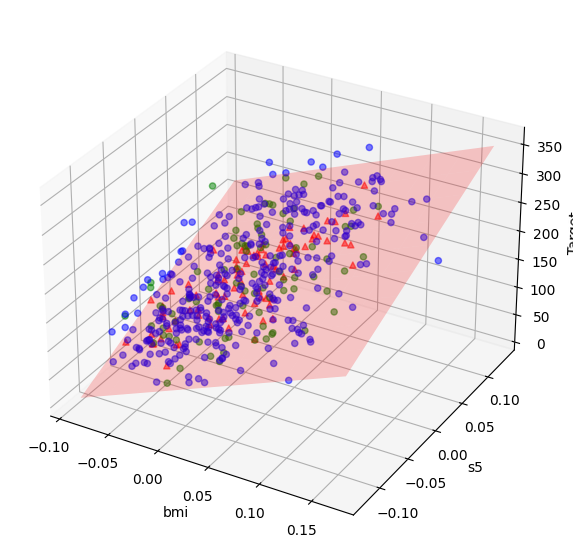

In [117]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a coordinate grid
x1 = np.linspace(diabetes_df[['bmi']].min(), diabetes_df[['bmi']].max(), num=10)
x2 = np.linspace(diabetes_df[['s5']].min(), diabetes_df[['s5']].max(), num=10)
x1, x2 = np.meshgrid(x1, x2)

grid_points = np.column_stack((x1.reshape(-1), x2.reshape(-1)))

y_pred_tt = model.predict(grid_points).reshape(x1.shape)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train[['bmi']], train[['s5']], train[['target']], c='blue', marker='o', alpha=0.5)
ax.scatter(test[['bmi']], test[['s5']], test[['target']], c='green', marker='o', alpha=0.5)
ax.scatter(test[['bmi']], test[['s5']], model.predict(test[['bmi', 's5']]), c='red', marker='^', alpha=0.5, label='Prediction')

ax.plot_surface(x1, x2, y_pred_tt, color='red', alpha=0.2)
ax.set_xlabel('bmi')
ax.set_ylabel('s5')
ax.set_zlabel('Target')
plt.show()

# 8. Conclusion